(pq-example)=
# PQ curve limits

## Introduction
This example demonstrates how PQ curves are built in SHOP, and how the PQ curves are affected by different limits on production and discharge.

An introduction to PQ curves can be found [here](pq_curves).

The model setup for this example is available in the following format:

- pyshop
    - [](pq_example_case.py)
  
For saving PQ curves, use the command [save pq_curves /on](save_pq_curves). Note that only the PQ curves for the latest iteration is saved.

In [1]:
#Necessary imports
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px

from pyshop import ShopSession

#Functions used in this example for building a basic SHOP model and running it
from pq_example_case import build_model, run_model

## Create a SHOP session and import model
We will use a simple example model with one reservoir and one plant.

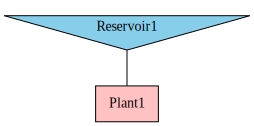

In [2]:
#Create a standard ShopSession
shop=ShopSession()
#Build a basic SHOP model
build_model(shop)
#Display topology to the screen
display(shop.model.build_connection_tree())

## Turbine efficiency curves
In addition to the net generator head, SHOP uses the generator attributes [gen_eff_curve](generator:gen_eff_curve) and [turb_eff_curves](generator:turb_eff_curves) to build the PQ curves. The [turb_eff_curves](generator:turb_eff_curves) is the most important of these attributes, and describe the turbine efficiency as a function of discharge for different net head values. The plot below shows the [turb_eff_curves](generator:turb_eff_curves) for our generator.

In [3]:
for gen in shop.model.generator:
    #Get generator turbine efficiency curves
    turb_eff_curves=gen.turb_eff_curves.get()   

    #Create figure   
    fig = go.Figure()  
    x_discharge = pd.DataFrame([], dtype="float64")
    y_net_head = pd.Series([], dtype="float64")
    z_efficiency = pd.DataFrame([], dtype="float64")
    
    for curve in turb_eff_curves:
        if (len(x_discharge) > 0):
            x_discharge = pd.concat([x_discharge, pd.Series(curve.index)], axis=1)
        else:
            x_discharge = pd.concat([pd.Series(curve.index)], axis=1)
        
        if (len(y_net_head) > 0):
            y_net_head = pd.concat([y_net_head, pd.Series(curve.name)])
        else:
            y_net_head = pd.concat([pd.Series(curve.name)])
            
        if (len(z_efficiency) > 0):
            z_efficiency = pd.concat([z_efficiency, pd.Series(curve.values)], axis=1)
        else:
            z_efficiency = pd.concat([pd.Series(curve.values)], axis=1)
    
    title_name="<b> Turbine efficiency curves of "+gen.get_name()+"</b>"
    fig = go.Figure(data=[go.Surface(x=x_discharge.values.T, y=y_net_head.values, z=z_efficiency.values.T)])
    fig.update_layout(scene = dict(
                        xaxis_title="<b>Discharge</b> (m<sup>3</sup>/s)",
                        yaxis_title="<b>Net head</b> (meter)",
                        zaxis_title="<b>Efficiency</b> (%)"),
                title=title_name, 
                scene_camera_eye=dict(x=1.5, y=-1.8, z=1.24),
                width=700, height=500,
                margin=dict(r=10, b=10, l=10, t=50))            
    fig.show()

## Run model and plot results

We start by running the example model.

In [4]:
run_model(shop)

In our example case, the reservoir goes from being full to being empty, so that the net head varies from its maximum to its minimum.

In [5]:
for rsv in shop.model.reservoir: 
    # Reservoir water level trajectory
    fig = go.Figure()        
    water_level=rsv.head.get()
    fig.add_trace(go.Scatter(x=water_level.index, y=water_level.values, name="Reservoir water level", marker_color="red"))     
    
    # Regulation max water level 
    max_level=rsv.hrl.get()
    txy_max_level=pd.Series(index=water_level.index, dtype="float64")
    txy_max_level=txy_max_level.fillna(max_level)
    fig.add_trace(go.Scatter(x=txy_max_level.index, y=txy_max_level.values, name="Reservoir regulation max water level", marker_color="rgb(0, 0, 255)", line=dict(width=3, dash="dot"))) 

    # Regulation min water level . 
    min_level=rsv.lrl.get()
    txy_min_level=pd.Series(index=water_level.index, dtype="float64")
    txy_min_level=txy_min_level.fillna(min_level)
    fig.add_trace(go.Scatter(x=txy_min_level.index, y=txy_min_level.values, name="Reservoir regulation min water level", marker_color="rgb(0, 200, 0)", line=dict(width=3, dash="dot")))  

    change = water_level.values[-1] - water_level.values[0]
    change = "{:,.4f}".format(change)
    change_pencentage = (water_level.values[-1] - water_level.values[0])/(rsv.hrl.get() - rsv.lrl.get()) * 100
    change_pencentage = "{:,.2f}".format(change_pencentage)
    fig.update_layout(title="<b>Reservoir water level trajectory of "+rsv.get_name()+"</b><br> (Change "+str(change)+" meter, "+str(change_pencentage)+"%)<br>", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Water level</b> (meter above sea level)")
    fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=-0.5, xanchor="center", x=0.5))
    fig.show()

for plant in shop.model.plant:
    eff_head=plant.eff_head.get()
    fig = go.Figure() 
    fig.add_trace(go.Scatter(x=eff_head.index, y=eff_head.values, name=str(eff_head.name), mode="lines+markers", line=dict(width=2)))    
    fig.update_layout(title="<b>Effective head of "+gen.get_name(), xaxis_title="<b>Time</b>", yaxis_title="<b>Eff head </b> (m)", colorway=px.colors.qualitative.Light24)
    fig.show()
    

The plots below show the generator's [original_pq_curves](generator:original_pq_curves), [convex_pq_curves](generator:convex_pq_curves) and [final_pq_curves](generator:final_pq_curves). Since no other limits have been set, the PQ curves are limited by the minimum and maximum discharge points from the [turb_eff_curves](generator:turb_eff_curves).

In [6]:
for gen in shop.model.generator: 

    #Get generator discharge and production
    discharge = gen.discharge.get()
    production = gen.production.get()
    
    #Get PQ curves
    original_pq_curve=gen.original_pq_curves.get()
    convex_pq_curve=gen.convex_pq_curves.get()
    final_pq_curve=gen.final_pq_curves.get()

    #Plot original PQ curves     
    fig = go.Figure() 
    for i, curve in enumerate(original_pq_curve):               
        if i%6==0: #plot every 6th hour only
            fig.add_trace(go.Scatter(x=curve.index, y=curve.values, name=str(curve.name), mode="lines+markers", line=dict(width=2)))    
    fig.update_layout(title="<b>Original PQ curves of "+gen.get_name(), xaxis_title="<b>Discharge</b> (m<sup>3</sup>/s)", yaxis_title="<b>Production</b> (MW)", colorway=px.colors.sequential.Plasma)
    fig.show()
    
    #Plot convex PQ curves
    fig = go.Figure() 
    for i, curve in enumerate(convex_pq_curve):   
        if i%6==0: #plot every 6th hour only
            fig.add_trace(go.Scatter(x=curve.index, y=curve.values, name=str(curve.name), mode="lines+markers", line=dict(width=2))) 
    fig.update_layout(title="<b>Convex PQ curves of "+gen.get_name(), xaxis_title="<b>Discharge</b> (m<sup>3</sup>/s)", yaxis_title="<b>Production</b> (MW)", colorway=px.colors.sequential.Plasma)
    fig.show()
    
    #Plot final PQ curves
    fig = go.Figure()
    for i, curve in enumerate(final_pq_curve):                
        if i%6==0: #plot every 6th hour only
            fig.add_trace(go.Scatter(x=curve.index, y=curve.values, name=str(curve.name), mode="lines+markers", line=dict(width=2)))
            
        # Add working point for each time                                            
        current_discharge = discharge.loc[curve.name]
        current_production = production.loc[curve.name]
        if i%6==0: #plot every 6th hour only
            fig.add_trace(go.Scatter(x=[current_discharge], y=[current_production], mode="markers", marker_symbol="x", marker=dict(color="Black", size=5), name="working point", showlegend=False))
    fig.add_trace(go.Scatter(x=[current_discharge], y=[current_production], mode="markers", marker_symbol="x", marker=dict(color="Black", size=5), name="working point"))
    fig.update_layout(title="<b>Final PQ curves of "+gen.get_name(), xaxis_title="<b>Discharge</b> (m<sup>3</sup>/s)", yaxis_title="<b>Production</b> (MW)", colorway=px.colors.sequential.Plasma)
    fig.show()

## Production limits

We will now run the example case again, but this time wih stricter limits on production; [p_min](generator:p_min) and [p_max](generator:p_max).

In [7]:
#Create a standard ShopSession
shop2=ShopSession()
#Build a basic SHOP model
build_model(shop2)
#Set the p_min and p_max attributes
for gen in shop2.model.generator:
    gen.p_min.set(20)
    gen.p_max.set(82)
#Run model
run_model(shop2)

Now the PQ curves are limited from below by the minimum production [p_min](generator:p_min). From above the curves are limited by the maximum production [p_max](generator:p_max) while the net head is high, while for lower net heads the PQ curve is still limited by the maximum discharge from the [turb_eff_curves](generator:turb_eff_curves).

In [8]:
for gen in shop2.model.generator: 
    original_pq_curve=gen.original_pq_curves.get()
    fig = go.Figure() 
    for i, curve in enumerate(original_pq_curve):               
        if i%6==0: #plot every 6th hour only
            fig.add_trace(go.Scatter(x=curve.index, y=curve.values, name=str(curve.name), mode="lines+markers", line=dict(width=2)))    
    fig.add_trace(go.Scatter(x=[25,100], y=[gen.p_max.get()]*2, name="P_max", mode="lines", line=dict(dash="dash",width=2,color="black")))
    fig.add_trace(go.Scatter(x=[25,100], y=[gen.p_min.get()]*2, name="P_min", mode="lines", line=dict(dash="dash",width=2,color="black")))
    fig.update_layout(title="<b>Original PQ curves of "+gen.get_name(), xaxis_title="<b>Discharge</b> (m<sup>3</sup>/s)", yaxis_title="<b>Production</b> (MW)", colorway=px.colors.sequential.Plasma)
    fig.show()
    

## Discharge limits

The default behaviour of SHOP is to find the discharge limits from the minimum discharge points of the [turb_eff_curves](generator:turb_eff_curves). Explicit discharge limits can be set using the head-dependent generator attributes [min_discharge](generator:min_discharge) and [max_discharge](generator:max_discharge). The same attributes are also available on the [needle_combination](needle_combination) object, which will take precedence over the generator attributes if both are defined. 

We define and plot head dependent discharge limits below:

In [9]:
q_min=pd.Series([45.0, 69.0], index=[90.0, 100.0])
q_max=pd.Series([85.0, 109.0], index=[90.0, 100.0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=q_min.values, y=q_min.index, name="min discharge"))
fig.add_trace(go.Scatter(x=q_max.values, y=q_max.index, name="max discharge"))
fig.update_layout(title="<b>Head dependent min and max discharge limits for "+gen.get_name(), yaxis_title="<b>Head</b> (m)", xaxis_title="<b>Discharge</b> (m<sup>3</sup>/s)")
fig.show()

We set the discharge limits in SHOP and rerun the model.

In [10]:
#Create a standard ShopSession
shop3=ShopSession()
#Build a basic SHOP model
build_model(shop3)
#set the min_discharge and max_discharge attributes
q_min=pd.Series([45.0, 69.0], index=[90.0, 100.0])
q_max=pd.Series([85.0, 109.0], index=[90.0, 100.0])
for gen in shop3.model.generator:
    gen.min_discharge.set(q_min)
    gen.max_discharge.set(q_max)
#Run model
run_model(shop3)

Now we see that the PQ curves are limited by the head-dependent [min_discharge](generator:min_discharge) and [max_discharge](generator:max_discharge) attributes.

In [11]:
for gen in shop3.model.generator: 
    original_pq_curve=gen.original_pq_curves.get() 
    fig = go.Figure() 
    for i, curve in enumerate(original_pq_curve):              
        if i%6==0: #plot every 6th hour only
            fig.add_trace(go.Scatter(x=curve.index, y=curve.values, name=str(curve.name), mode="lines+markers", line=dict(width=2)))    
    fig.update_layout(title="<b>Original PQ curves of "+gen.get_name(), xaxis_title="<b>Discharge</b> (m<sup>3</sup>/s)", yaxis_title="<b>Production</b> (MW)", colorway=px.colors.sequential.Plasma)
    fig.show()

As shown in the figure below, the optimized discharge of the generator is limited by the set max_discharge limit when the effective generator head is low. For higher head values, the generator discharges 90 m<sup>3</sup>/s since this is the best operating point for the plant. 

Note that the max_discharge limit was not defined for head values lower than 90 m, but the effective head of the generator is lower than this for several time steps. SHOP assumes that the limits defined for the lowest and highest head values are valid for all head values outside the range covered by the input data, which can be seen in the figure below.

In [12]:
for gen in shop3.model.generator: 
    head = gen.eff_head.get()
    discharge = gen.discharge.get()
    q_min = gen.min_discharge.get()
    q_max = gen.max_discharge.get()
    
    fig = go.Figure() 
    fig.add_trace(go.Scatter(x=discharge.values, y=head.values, name="discharge",mode="markers"))
    fig.add_trace(go.Scatter(x=q_min.values, y=q_min.index, name="min discharge",mode="lines"))
    fig.add_trace(go.Scatter(x=q_max.values, y=q_max.index, name="max discharge",mode="lines"))    
    fig.update_layout(title="<b>Discharge and effective head of "+gen.get_name(), xaxis_title="<b>Discharge</b> (m<sup>3</sup>/s)", yaxis_title="<b>Effective head</b> (m)", colorway=px.colors.sequential.Plasma)
    fig.show()
    